In [1]:
#import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import random

#set seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#enable mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


#in case of a deletion of a directory
#import shutil
#shutil.rmtree("/content/TensorboardLogs")

In [2]:
# import the cats and dogs dataset using tfds
dataset = tfds.load('cats_vs_dogs',
                    as_supervised = True,
                    shuffle_files = True,
                    split = ['train'],
                    batch_size=None,
                    )[0]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHBRPOI/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
def create_train_test_split(tensorflow_dataset, train_multiplier = 0.8, batch_size = 32):
    """
    Splits a TensorFlow dataset into training and test subsets.

    This function shuffles the input dataset and then divides it into
    training and test subsets based on the provided train_multiplier value.

    Parameters
    ----------
    tensorflow_dataset : tf.data.Dataset
        The input TensorFlow dataset to be split.

    train_multiplier : float
        The fraction of the total dataset to use as training data.
        Expected to be in the range [0, 1]. For example, a value
        of 0.8 would allocate 80% of the data to the training set.

    batch_size: int
        Number of data in a batch

    Returns
    -------
    tuple of tf.data.Dataset
    A tuple containing two datasets: (train_dataset, test_dataset).

    """
    #shuffle the dataset first
    dataset_size = tf.data.experimental.cardinality(tensorflow_dataset).numpy()
    tensorflow_dataset = tensorflow_dataset.shuffle(500) #a large buffer size need lots of memory resources

    #split the dataset
    train_size = int(train_multiplier*dataset_size)
    train_dataset = tensorflow_dataset.take(train_size)
    test_dataset = tensorflow_dataset.skip(train_size)

    #batch and prefetch the datasets
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset,test_dataset

def variable_length_resizing(image,label,target_size):
  """
  Image resizing function for variable length image inputs.
  We can't use `layers.Resizing` for batches having different width and lengths.

  Parameters
  ---------
  image: uint
    (None,None,3) type image

  label: int
    Label of the image

  target_size: int, tuple
    targetsize of the image

  Returns
  -------
  A tuple: resized_image,label

  Example Usage
  -------------
  train_dataset = train_dataset.unbatch().map(lambda x,y: variable_length_resizing(x,y,(180,180)))
  """
  return tf.image.resize(image, target_size),label

def define_callbacks(model):
  es = tf.keras.callbacks.EarlyStopping(patience = 3,verbose = 1, restore_best_weights = True)
  mc = tf.keras.callbacks.ModelCheckpoint(filepath = f"./ModelCheckpoints/{model.name}.ckpt",
                                         save_best_only = True,
                                         save_weights_only = True)
  tb = tf.keras.callbacks.TensorBoard(log_dir = f"./TensorboardLogs/{model.name}")
  return es,mc,tb

In [4]:
dataset_resized = dataset.map(lambda x,y: variable_length_resizing(x,y,(150,150)))

In [5]:
#create the train and validation datasets
train_dataset,validation_dataset = create_train_test_split(dataset_resized,batch_size = 8)
train_dataset,validation_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [6]:
#create a model dictionary
models = {}
histories = {}

#set up global variables
MODEL_NAME = 'model1'
HISTORY_NAME = 'history1'
FILTERS = 32
ACTIVATION = 'relu'
#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)


#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 5
)

Epoch 1/5
2327/2327 [==============================] - 70s 25ms/step - loss: 0.6371 - accuracy: 0.6349 - val_loss: 0.5766 - val_accuracy: 0.7105
Epoch 2/5
2327/2327 [==============================] - 66s 28ms/step - loss: 0.5284 - accuracy: 0.7411 - val_loss: 0.5497 - val_accuracy: 0.7301
Epoch 3/5
2327/2327 [==============================] - 78s 33ms/step - loss: 0.4556 - accuracy: 0.7906 - val_loss: 0.4836 - val_accuracy: 0.7724
Epoch 4/5
2327/2327 [==============================] - 81s 34ms/step - loss: 0.4126 - accuracy: 0.8127 - val_loss: 0.4381 - val_accuracy: 0.7975
Epoch 5/5
2327/2327 [==============================] - 74s 32ms/step - loss: 0.3816 - accuracy: 0.8279 - val_loss: 0.4444 - val_accuracy: 0.7956


In [8]:
#set up global variables
MODEL_NAME = 'model2'
HISTORY_NAME = 'history2'
FILTERS = 32
ACTIVATION = 'relu'

#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#create callbacks
es,mc,tb = define_callbacks(models[MODEL_NAME])

#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = int(0.2*tf.data.experimental.cardinality(validation_dataset).numpy()),
    epochs = 5
)

Epoch 1/5
2327/2327 [==============================] - 55s 22ms/step - loss: 0.6651 - accuracy: 0.5838 - val_loss: 0.6277 - val_accuracy: 0.6918
Epoch 2/5
2327/2327 [==============================] - 53s 23ms/step - loss: 0.6195 - accuracy: 0.6615 - val_loss: 0.5715 - val_accuracy: 0.7295
Epoch 3/5
2327/2327 [==============================] - 53s 22ms/step - loss: 0.5760 - accuracy: 0.7016 - val_loss: 0.5470 - val_accuracy: 0.7500
Epoch 4/5
2327/2327 [==============================] - 53s 23ms/step - loss: 0.5557 - accuracy: 0.7194 - val_loss: 0.5479 - val_accuracy: 0.7284
Epoch 5/5
2327/2327 [==============================] - 61s 26ms/step - loss: 0.5396 - accuracy: 0.7352 - val_loss: 0.4985 - val_accuracy: 0.7500


Select `Flatten`

Try to change activation.



In [9]:
#set up global variables
MODEL_NAME = 'model3'
HISTORY_NAME = 'history3'
ACTIVATION = 'swish'
FILTERS = 32

#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)



#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = int(0.2*tf.data.experimental.cardinality(validation_dataset).numpy()),
    epochs = 5,
)

Epoch 1/5
2327/2327 [==============================] - 55s 23ms/step - loss: 0.5948 - accuracy: 0.6774 - val_loss: 0.4896 - val_accuracy: 0.7662
Epoch 2/5
2327/2327 [==============================] - 56s 24ms/step - loss: 0.4878 - accuracy: 0.7716 - val_loss: 0.4731 - val_accuracy: 0.7974
Epoch 3/5
2327/2327 [==============================] - 52s 22ms/step - loss: 0.4338 - accuracy: 0.8027 - val_loss: 0.4194 - val_accuracy: 0.8308
Epoch 4/5
2327/2327 [==============================] - 50s 21ms/step - loss: 0.3843 - accuracy: 0.8274 - val_loss: 0.4341 - val_accuracy: 0.8028
Epoch 5/5
2327/2327 [==============================] - 53s 23ms/step - loss: 0.3361 - accuracy: 0.8536 - val_loss: 0.4013 - val_accuracy: 0.8427


Select `swish` activation.
Increase the epochs (bigger models require more time to train).

--------

In [10]:
#set up global variables
MODEL_NAME = 'model4'
HISTORY_NAME = 'history4'
ACTIVATION = 'swish'
FILTERS = 64

#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)



#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = int(0.2*tf.data.experimental.cardinality(validation_dataset).numpy()),
    epochs = 10,
)

Epoch 1/10
2327/2327 [==============================] - 59s 24ms/step - loss: 0.5825 - accuracy: 0.6891 - val_loss: 0.4942 - val_accuracy: 0.7769
Epoch 2/10
2327/2327 [==============================] - 56s 24ms/step - loss: 0.4819 - accuracy: 0.7738 - val_loss: 0.4389 - val_accuracy: 0.8179
Epoch 3/10
2327/2327 [==============================] - 55s 23ms/step - loss: 0.4219 - accuracy: 0.8072 - val_loss: 0.4580 - val_accuracy: 0.8017
Epoch 4/10
2327/2327 [==============================] - 58s 25ms/step - loss: 0.3570 - accuracy: 0.8450 - val_loss: 0.4738 - val_accuracy: 0.8147
Epoch 5/10
2327/2327 [==============================] - 57s 24ms/step - loss: 0.2823 - accuracy: 0.8826 - val_loss: 0.4745 - val_accuracy: 0.8233
Epoch 6/10
2327/2327 [==============================] - 56s 24ms/step - loss: 0.2230 - accuracy: 0.9078 - val_loss: 0.4943 - val_accuracy: 0.8244
Epoch 7/10
2327/2327 [==============================] - 61s 26ms/step - loss: 0.1736 - accuracy: 0.9287 - val_loss: 1.3750 -

64 filters resulted in overfitting. The first 5 epochs are not better. Data augmentation is not a good choice because the dataset is big enough. Increase the number of layers.


In [11]:
#set up global variables
MODEL_NAME = 'model5'
HISTORY_NAME = 'history5'
ACTIVATION = 'swish'
FILTERS = 32

#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)



#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = int(0.2*tf.data.experimental.cardinality(validation_dataset).numpy()),
    epochs = 5,
)

Epoch 1/5
2327/2327 [==============================] - 55s 22ms/step - loss: 0.6103 - accuracy: 0.6604 - val_loss: 0.5304 - val_accuracy: 0.7338
Epoch 2/5
2327/2327 [==============================] - 55s 23ms/step - loss: 0.4798 - accuracy: 0.7725 - val_loss: 0.3753 - val_accuracy: 0.8416
Epoch 3/5
2327/2327 [==============================] - 53s 22ms/step - loss: 0.3868 - accuracy: 0.8268 - val_loss: 0.3571 - val_accuracy: 0.8491
Epoch 4/5
2327/2327 [==============================] - 55s 23ms/step - loss: 0.3232 - accuracy: 0.8617 - val_loss: 0.3316 - val_accuracy: 0.8707
Epoch 5/5
2327/2327 [==============================] - 52s 22ms/step - loss: 0.2740 - accuracy: 0.8827 - val_loss: 0.2769 - val_accuracy: 0.8869


Increase the number of layers even further.

In [12]:
#set up global variables
MODEL_NAME = 'model6'
HISTORY_NAME = 'history6'
ACTIVATION = 'swish'
FILTERS = 32

#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)



#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = int(0.2*tf.data.experimental.cardinality(validation_dataset).numpy()),
    epochs = 5,
)

Epoch 1/5
2327/2327 [==============================] - 56s 22ms/step - loss: 0.6527 - accuracy: 0.6043 - val_loss: 0.5863 - val_accuracy: 0.6821
Epoch 2/5
2327/2327 [==============================] - 55s 23ms/step - loss: 0.5299 - accuracy: 0.7314 - val_loss: 0.4641 - val_accuracy: 0.7629
Epoch 3/5
2327/2327 [==============================] - 56s 24ms/step - loss: 0.4127 - accuracy: 0.8067 - val_loss: 0.4042 - val_accuracy: 0.8125
Epoch 4/5
2327/2327 [==============================] - 54s 23ms/step - loss: 0.3272 - accuracy: 0.8556 - val_loss: 0.3034 - val_accuracy: 0.8793
Epoch 5/5
2327/2327 [==============================] - 54s 23ms/step - loss: 0.2662 - accuracy: 0.8820 - val_loss: 0.2660 - val_accuracy: 0.8901


Almost the same performance. Lets train them till the ned and select the best one.

In [13]:
#set up global variables
MODEL_NAME = 'model7'
HISTORY_NAME = 'history7'
ACTIVATION = 'swish'
FILTERS = 32

#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#define the callbacks
es,mc,tb = define_callbacks(models[MODEL_NAME])

#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = int(0.2*tf.data.experimental.cardinality(validation_dataset).numpy()),
    epochs = 100,
    callbacks = [es,mc,tb]
)

Epoch 1/100
2327/2327 [==============================] - 55s 22ms/step - loss: 0.6120 - accuracy: 0.6591 - val_loss: 0.5064 - val_accuracy: 0.7586
Epoch 2/100
2327/2327 [==============================] - 52s 22ms/step - loss: 0.4882 - accuracy: 0.7681 - val_loss: 0.4038 - val_accuracy: 0.8244
Epoch 3/100
2327/2327 [==============================] - 50s 21ms/step - loss: 0.4032 - accuracy: 0.8156 - val_loss: 0.3406 - val_accuracy: 0.8524
Epoch 4/100
2327/2327 [==============================] - 50s 21ms/step - loss: 0.3278 - accuracy: 0.8569 - val_loss: 0.2738 - val_accuracy: 0.8901
Epoch 5/100
2327/2327 [==============================] - 52s 22ms/step - loss: 0.2769 - accuracy: 0.8806 - val_loss: 0.2742 - val_accuracy: 0.8858
Epoch 6/100
2327/2327 [==============================] - 54s 23ms/step - loss: 0.2352 - accuracy: 0.9025 - val_loss: 0.2678 - val_accuracy: 0.8836
Epoch 7/100
2327/2327 [==============================] - 53s 23ms/step - loss: 0.2003 - accuracy: 0.9155 - val_loss: 0

In [14]:
#set up global variables
MODEL_NAME = 'model8'
HISTORY_NAME = 'history8'
ACTIVATION = 'swish'
FILTERS = 32

#create the model
inputs = tf.keras.Input(shape = (150,150,3))
x = layers.Rescaling(1/255.)(inputs)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = FILTERS,kernel_size = 3, activation = ACTIVATION)(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

models[MODEL_NAME] = tf.keras.Model(inputs,outputs,name = MODEL_NAME)

#compile the model
models[MODEL_NAME].compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#define the callbacks
es,mc,tb = define_callbacks(models[MODEL_NAME])

#fit the model
histories[HISTORY_NAME] = models[MODEL_NAME].fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = int(0.2*tf.data.experimental.cardinality(validation_dataset).numpy()),
    epochs = 100,
    callbacks = [es,mc,tb]
)

Epoch 1/100
2327/2327 [==============================] - 66s 27ms/step - loss: 0.6501 - accuracy: 0.6090 - val_loss: 0.5650 - val_accuracy: 0.6994
Epoch 2/100
2327/2327 [==============================] - 59s 25ms/step - loss: 0.5283 - accuracy: 0.7341 - val_loss: 0.4730 - val_accuracy: 0.7716
Epoch 3/100
2327/2327 [==============================] - 55s 23ms/step - loss: 0.4049 - accuracy: 0.8145 - val_loss: 0.3517 - val_accuracy: 0.8394
Epoch 4/100
2327/2327 [==============================] - 56s 24ms/step - loss: 0.3249 - accuracy: 0.8571 - val_loss: 0.2913 - val_accuracy: 0.8793
Epoch 5/100
2327/2327 [==============================] - 55s 23ms/step - loss: 0.2740 - accuracy: 0.8796 - val_loss: 0.3342 - val_accuracy: 0.8534
Epoch 6/100
2327/2327 [==============================] - 52s 22ms/step - loss: 0.2295 - accuracy: 0.9039 - val_loss: 0.2853 - val_accuracy: 0.8858
Epoch 7/100
2327/2327 [==============================] - 56s 24ms/step - loss: 0.1943 - accuracy: 0.9190 - val_loss: 0

In [16]:
#upload the experiments
#!tensorboard dev upload --logdir /content/TensorboardLogs

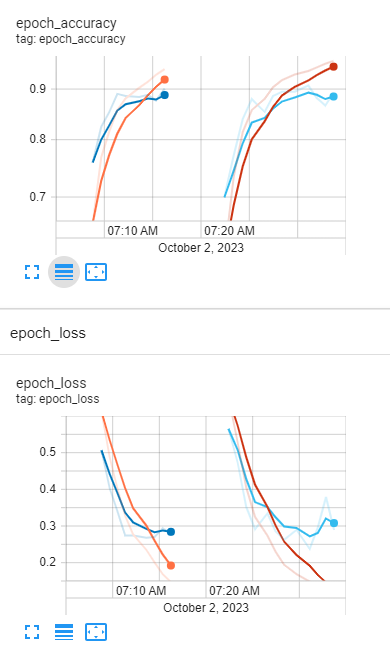

The models perform similar. The former (model7) converges a bit quicker.

In [17]:
models['model7'].save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
